# Бинарная классификация

In [ ]:
import glob
import os
import seaborn as sns


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import average_precision_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Описание набора данных

Вам дана некоторая часть ежедневной глобальной сводки о поверхности Земли (Global Surface Summary of the Day - GSOD), полученной из набора данных Integrated Surface Hourly (ISH). Набор данных ISH включает в себя глобальную сводку данных, полученных из Климатологического центра ВВС США. В некоторые периоды времени данные могут быть недоступны, например, из-за ограничений или проблем со связью.

Используемая в работе часть набора данных включает в себя информацию по 15 городам РФ за 2019-2021 годы.

[Описание исходного набора данных](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516).

[Подробное описание содержимого](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt).

In [ ]:
 # для Collab

In [ ]:
files = os.path.join("/content", '*.csv')
files = glob.glob(files)
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
df.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
0,23078099999,2019-01-01,69.333333,88.25,64.0,"NORIL SK, RS",4.0,8,-2.7,8,...,21.4,35.0,6.1,*,-0.8,,0.16,F,22.4,1000
1,23078099999,2019-01-02,69.333333,88.25,64.0,"NORIL SK, RS",6.1,8,-0.2,8,...,21.4,29.1,7.2,*,3.6,,0.04,F,22.0,1000
2,23078099999,2019-01-03,69.333333,88.25,64.0,"NORIL SK, RS",-0.2,8,-5.4,8,...,19.4,29.1,8.2,,-9.8,*,0.00,E,999.9,1000
3,23078099999,2019-01-04,69.333333,88.25,64.0,"NORIL SK, RS",-0.2,8,-5.6,8,...,19.4,999.9,5.7,*,-11.2,,0.03,F,22.0,1000
4,23078099999,2019-01-05,69.333333,88.25,64.0,"NORIL SK, RS",-4.5,8,-10.2,8,...,17.5,999.9,6.6,,-18.6,*,0.05,F,20.5,1000


### Задача

**Ваша задача - попытаться определить по данным, был ли в какой-либо из дней туман.**

### Подготовка данных

Для решения, вам необходимо сначала выбрать и извлечь из исходного набора только значимые признаки.

Сначала посмотрите на исходный список полей:

In [ ]:
df.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'TEMP',
       'TEMP_ATTRIBUTES', 'DEWP', 'DEWP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES',
       'STP', 'STP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WDSP',
       'WDSP_ATTRIBUTES', 'MXSPD', 'GUST', 'MAX', 'MAX_ATTRIBUTES', 'MIN',
       'MIN_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNDP', 'FRSHTT'],
      dtype='object')

Предлагаем вам выбрать следующий набор полей: `'TEMP', 'DEWP', 'SLP', 'VISIB', 'WDSP', 'GUST', 'PRCP', 'SNDP'`.

Кроме того, из поля `'FRSHTT'` потребуется извлечь признаки `'RAIN'` и `'FOG'`, и присоединить их к вышеуказанному набору.

In [ ]:
new_df = df[['TEMP', 'DEWP', 'SLP', 'VISIB', 'WDSP', 'GUST', 'PRCP', 'SNDP']]

rains, fogs = [], []
for i in df.FRSHTT:
    i = str(i)
    fogs.append(1 if len(i) > 0 and i[0] == '1' else 0)
    rains.append(1 if len(i) > 1 and i[1] == '1' else 0)

new_df = new_df.join(pd.DataFrame({'RAIN': rains}))
new_df = new_df.join(pd.DataFrame({'FOG': fogs}))
new_df

,TEMP,DEWP,SLP,VISIB,WDSP,GUST,PRCP,SNDP,RAIN,FOG
0,4.0,-2.7,1010.6,1.7,19.9,35.0,0.16,22.4,0,1
1,6.1,-0.2,1010.4,1.7,18.7,29.1,0.04,22.0,0,1
2,-0.2,-5.4,1016.2,9.5,7.8,29.1,0.00,999.9,0,1
3,-0.2,-5.6,1013.5,8.5,14.8,999.9,0.03,22.0,0,1
4,-4.5,-10.2,1007.8,9.0,9.2,999.9,0.05,20.5,0,1
...,...,...,...,...,...,...,...,...,...,...
14549,-2.4,-7.0,9999.9,5.7,7.6,999.9,0.00,6.3,0,1
14550,-4.7,-9.9,9999.9,4.6,4.4,999.9,0.00,6.3,0,1
14551,0.0,-4.7,9999.9,3.8,3.7,999.9,0.00,5.9,0,1
14552,17.7,11.7,9999.9,5.6,8.7,999.9,0.02,5.9,0,1


Посчитайте и изучите корреляции между признаками.

Можете ли вы их как-то объяснить?

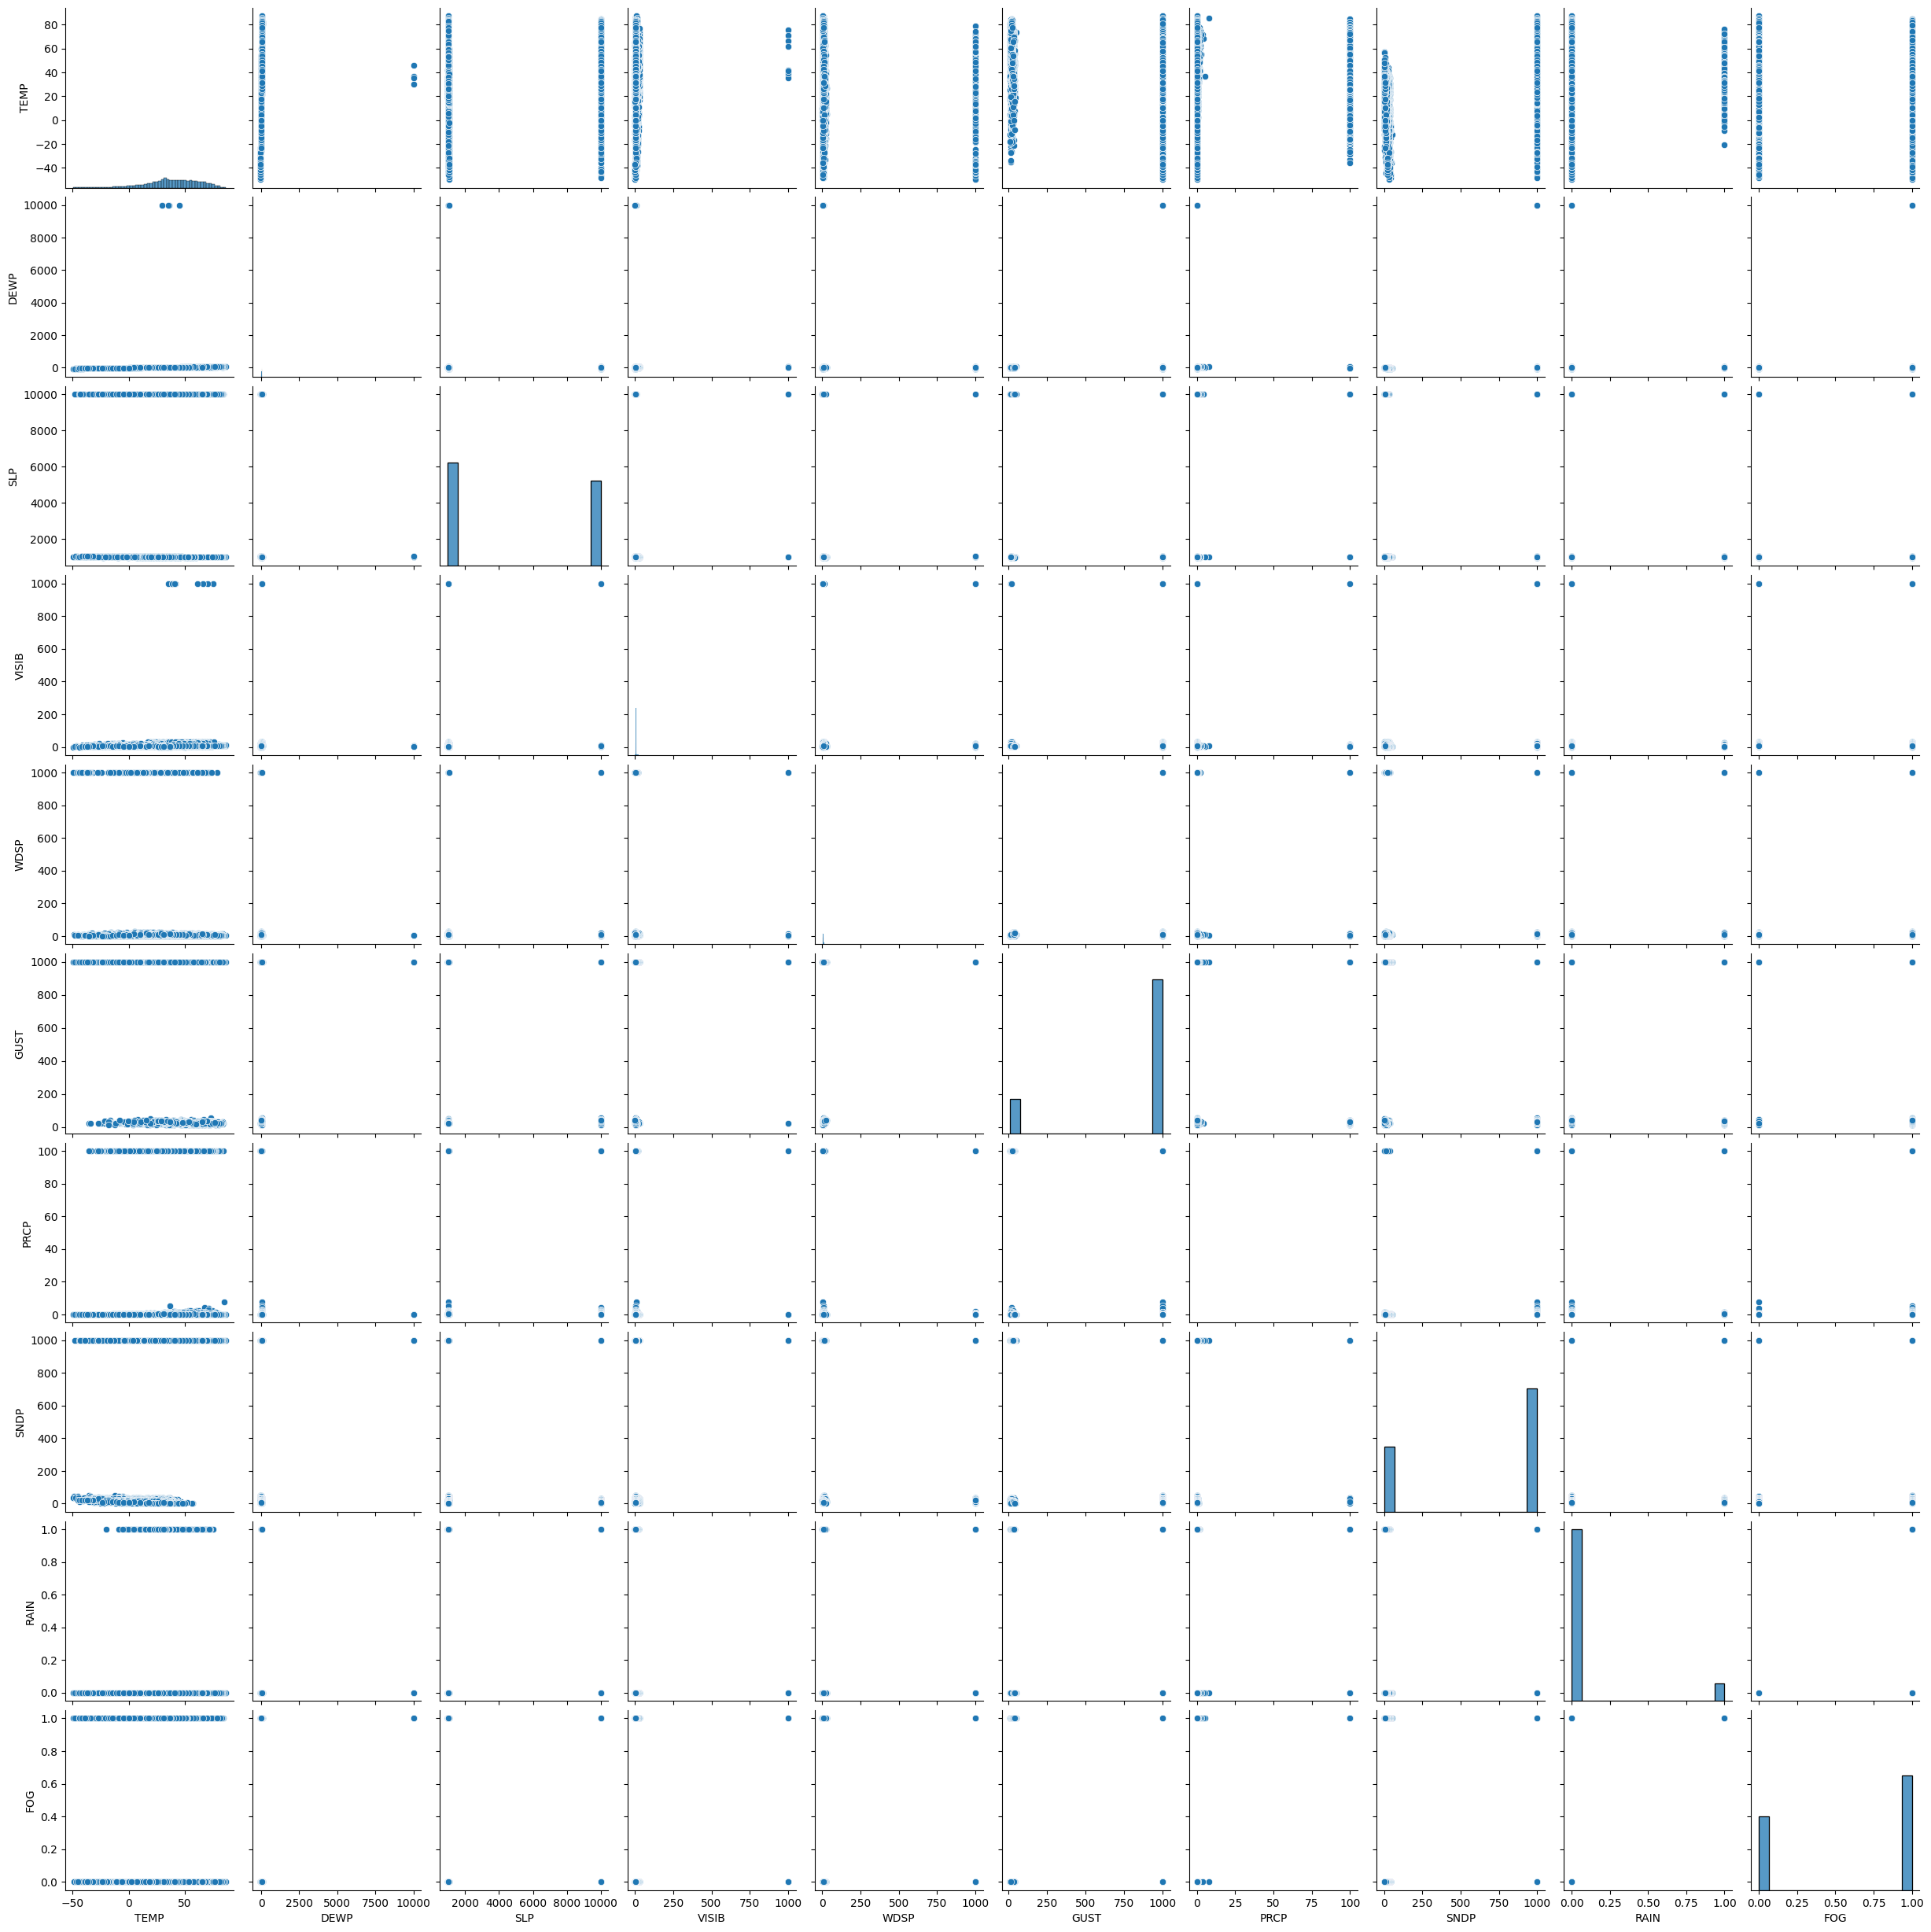

In [ ]:
sns.pairplot(new_df)

<Axes: >

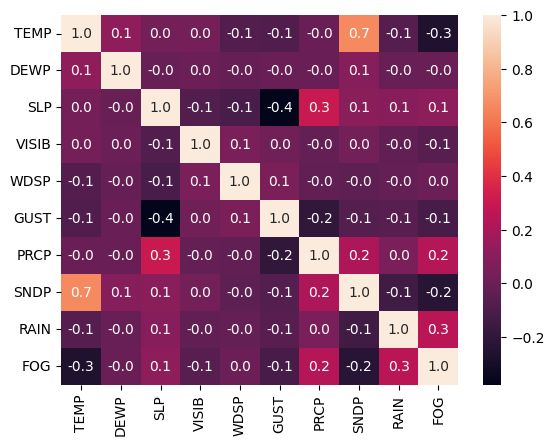

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt=".1f")

Если вы выводили получившийся после отбора полей набор, то могли обратить внимание на то, что некоторые поля содержат странные значения (например, 9999.9 в `SLP` или 999.9 в `GUST` и `SNDP`).

Вспомните, что выше была указана ссылка на описание содержимого. Кажется, пора ее изучить.

Прочтя описание, вы узнаете, что эти странные значения обозначают пропуск.

Первым решением, которое приходит в голову, наверняка, будет удаление всех данных, содержащих пропуск.

Давайте сделаем так, и посмотрим, что из этого выйдет.

In [ ]:
df_drop = new_df.drop(new_df[(new_df['TEMP'] == 9999.9) |
                             (new_df['DEWP'] == 9999.9) |
                             (new_df['SLP'] == 9999.9) |
                             (new_df['VISIB'] == 999.9) |
                             (new_df['WDSP'] == 999.9) |
                             (new_df['GUST'] == 999.9) |
                             (new_df['PRCP'] == 99.9) |
                             (new_df['RAIN'] == 99.9) |
                             (new_df['SNDP'] == 999.9)].index)
df_drop

,TEMP,DEWP,SLP,VISIB,WDSP,GUST,PRCP,SNDP,RAIN,FOG
0,4.0,-2.7,1010.6,1.7,19.9,35.0,0.16,22.4,0,1
1,6.1,-0.2,1010.4,1.7,18.7,29.1,0.04,22.0,0,1
14,7.3,3.7,1001.6,1.4,14.8,29.1,0.12,20.9,0,1
17,13.0,8.4,1000.3,1.9,19.7,29.1,0.05,24.8,0,1
31,-21.6,-26.7,1038.0,3.9,11.9,21.4,0.00,22.0,0,0
...,...,...,...,...,...,...,...,...,...,...
12791,-0.9,-6.7,1005.5,2.2,10.2,23.3,0.35,24.0,0,1
12793,-27.0,-34.1,1015.9,4.2,11.7,19.4,0.02,30.7,0,1
12794,-12.1,-19.0,1016.0,5.0,13.1,21.4,0.04,30.7,0,1
13608,28.2,25.0,1015.5,3.0,7.3,19.4,0.08,14.6,0,1


В результате вы должны увидеть, что у вас осталось всего 133 строки, то есть менее 1% исходных данных.

Получается, такой способ не работает. Что же тогда можно сделать?

Можно попробовать заменить пропущенные данные какими-то значениями. Данный подход называется "импутация" или "вменение" данных. Эта методология включает в себя различные методы:

* Замена отсутствующего значения конкретным значением. Используется, если известна предметная область набора данных. В нашем случае следует использовать этот метод при обработке `PRCP` и `SNDP` (обратите внимание на примечания).
* Вменение регрессии. Создание модели для прогнозирования наблюдаемого значения переменной на основе другой переменной. И дальнейшее использование модели для заполнения отсутствующего значения переменной. Используется в случаях, когда объекты в наборе данных зависят друг от друга.
* Простое вменение. Использование центральной тенденции признака, такой как среднее значение, медиана или мода. Будем использовать данный метод для всех остальных полей.
* Вменение KNN. Замена отсутствующих данных средним значением ближайших к нему соседей.

Повторим, что для полей `PRCP` и `SNDP` следует использовать замену отсутствующего значения конкретным значением (обратите внимание на примечания в описании данных). И простое вменение средним значением - для всех остальных полей.

**Примечание.** Если бы в вашем наборе были категориальные признаки, то проще всего было бы интерпретировать пропущенное значение, как ещё одну категорию.

In [ ]:
inds = new_df[(new_df['RAIN'] == 99.9)].index
for x in inds:
  new_df['RAIN'][x] = 0

inds = new_df[(new_df['TEMP'] == 9999.9)].index
for x in inds:
  new_df['TEMP'][x] = sum(new_df['TEMP'][:x])/ len(new_df['TEMP'][:x])

inds = new_df[((new_df['SLP'] == 9999.9))].index
for x in inds:
  new_df['SLP'][x] = sum(new_df['SLP'][:x])/ len(new_df['SLP'][:x])

inds = new_df[((new_df['DEWP'] == 9999.9))].index
for x in inds:
  new_df['DEWP'][x] = sum(new_df['DEWP'][:x])/ len(new_df['DEWP'][:x])

inds = new_df[((new_df['WDSP'] == 999.9))].index
for x in inds:
  new_df['WDSP'][x] = sum(new_df['WDSP'][:x])/ len(new_df['WDSP'][:x])

inds = new_df[((new_df['GUST'] == 999.9))].index
for x in inds:
  new_df['GUST'][x] = sum(new_df['GUST'][:x])/ len(new_df['GUST'][:x])

inds = new_df[((new_df['PRCP'] == 999.9))].index
for x in inds:
  new_df['PRCP'][x] = sum(new_df['PRCP'][:x])/ len(new_df['PRCP'][:x])

inds = new_df[((new_df['PRCP'] == 99.9))].index
for x in inds:
  new_df['PRCP'][x] = sum(new_df['PRCP'][:x])/ len(new_df['PRCP'][:x])

inds = new_df[((new_df['SNDP'] == 999.9))].index
for x in inds:
  new_df['SNDP'][x] = sum(new_df['SNDP'][:x])/ len(new_df['SNDP'][:x])
new_df

<ipython-input-10-019326a71a76>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['SLP'][x] = sum(new_df['SLP'][:x])/ len(new_df['SLP'][:x])
<ipython-input-10-019326a71a76>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['DEWP'][x] = sum(new_df['DEWP'][:x])/ len(new_df['DEWP'][:x])
<ipython-input-10-019326a71a76>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['WDSP'][x] = sum(new_df['WDSP'][:x])/ len(new_df['W

,TEMP,DEWP,SLP,VISIB,WDSP,GUST,PRCP,SNDP,RAIN,FOG
0,4.0,-2.7,1010.600000,1.7,19.900000,35.000000,0.16,22.400000,0,1
1,6.1,-0.2,1010.400000,1.7,18.700000,29.100000,0.04,22.000000,0,1
2,-0.2,-5.4,1016.200000,9.5,7.800000,29.100000,0.00,22.200000,0,1
3,-0.2,-5.6,1013.500000,8.5,14.800000,31.066667,0.03,22.000000,0,1
4,-4.5,-10.2,1007.800000,9.0,9.200000,31.066667,0.05,20.500000,0,1
...,...,...,...,...,...,...,...,...,...,...
14549,-2.4,-7.0,1014.728179,5.7,7.600000,25.767984,0.00,6.300000,0,1
14550,-4.7,-9.9,1014.728179,4.6,4.400000,25.767984,0.00,6.300000,0,1
14551,0.0,-4.7,1014.728179,3.8,3.700000,25.767984,0.00,5.900000,0,1
14552,17.7,11.7,1014.728179,5.6,8.700000,25.767984,0.02,5.900000,0,1


Посчитайте и изучите корреляции между признаками в получившемся после обработки пропущенных значений наборе.

Стало ли проще их объяснить?

<Axes: >

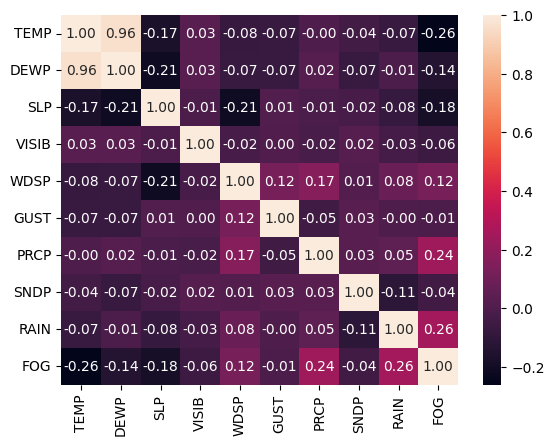

In [ ]:
sns.heatmap(new_df.corr(), annot=True, fmt=".2f")

Далее будем использовать получившийся набор.

Теперь:
* выделите из набора целевой признак `'FOG'`
* обозначьте целевой признак `y`
* обозначьте остальные признаки `X`
* разделите набор на обучающую и тестовую выборки с относительным размером тестовой выборки 0.4 и `random_state = 42` (чтобы иметь возможность воспроизвести результат)

In [ ]:
y = new_df['FOG']
X = new_df.drop('FOG', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

### Бинарная классификация

Теперь, после выполнения предыдущих шагов, у вас есть обработанный набор данных, который можно использовать для обучения.

#### Подбор гиперпараметров

Гиперпараметры — это параметры, которые не обучаются непосредственно в моделях. В scikit-learn они передаются в качестве аргументов конструктору объекта класса модели. Рекомендуется осуществлять поиск в пространстве гиперпараметров с целью поиска наилучшей оценки перекрестной проверки. То есть любой параметр, предоставленный при построении модели, можно оптимизировать таким образом.

Для поиска требуются:

* модель (регрессор или классификатор)
* пространство параметров
* метод поиска или выбора кандидатов
* схема перекрестной проверки
* функция оценки

В scikit-learn предусмотрены два общих подхода к поиску параметров:

* `GridSearchCV` рассматривает все комбинации параметров для заданных значений
* `RandomizedSearchCV` может выбирать заданное число кандидатов из пространства параметров с заданным распределением

У обоих этих инструментов есть аналоги `HalvingGridSearchCV` и `HalvingRandomSearchCV`, которые могут быть намного быстрее.

Используя `HalvingGridSearchCV` с `roc_auc` в качестве функционала качества (см. опциональный аргумент `scoring`), выберите две модели, которые продемонстрируют лучшие показатели AP(average_precision_score) и AUC ROC на тестовых выборках, среди следующих четырех:

* `LogisticRegression`
* `RidgeClassifier`
* `SGDClassifier` со стандартной функцией ошибки и логистической (`loss='log_loss'`)

Выведите параметр, при котором достигается наилучшие показатели.

Чтобы убедиться в том, что вы нашли максимум функционала качества, постройте графики их оценок, используя функцию `plot_scores`.

Используйте сетки параметров и число блоков `cv` указанные ниже.

**Не забудьте использовать опциональный параметр `random_state = 42` в конструкторах.**

**Примечание**. Если получите предупреждение (warning) от sklearn при использовании `LogisticRegression`, постарайтесь решить проблему самостоятельно.

In [ ]:
def plot_scores(search):
    _, ax = plt.subplots(figsize=(20, 8))
    results = pd.DataFrame(search.cv_results_)
    labels = results.params
    mean_scores = results["mean_test_score"]
    std_scores = results["std_test_score"]
    xs = np.arange(0, len(mean_scores))
    ax.plot(xs, mean_scores)
    ax.fill_between(xs, mean_scores - std_scores,
                    mean_scores + std_scores, alpha=0.4)
    ax.set_xticks(np.arange(0, len(labels), 2), labels[::2], rotation=90)
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("Mean Test Score")
    ax.set_xlabel("Iterations")

c_param_grid = {'C': np.logspace(1, 3, 100)}
a_param_grid = {'alpha': np.logspace(1, 3, 100)}
cv = 5

0.8390388009446017
0.8334145210942464
0.8200713583401966
0.9697574324273304


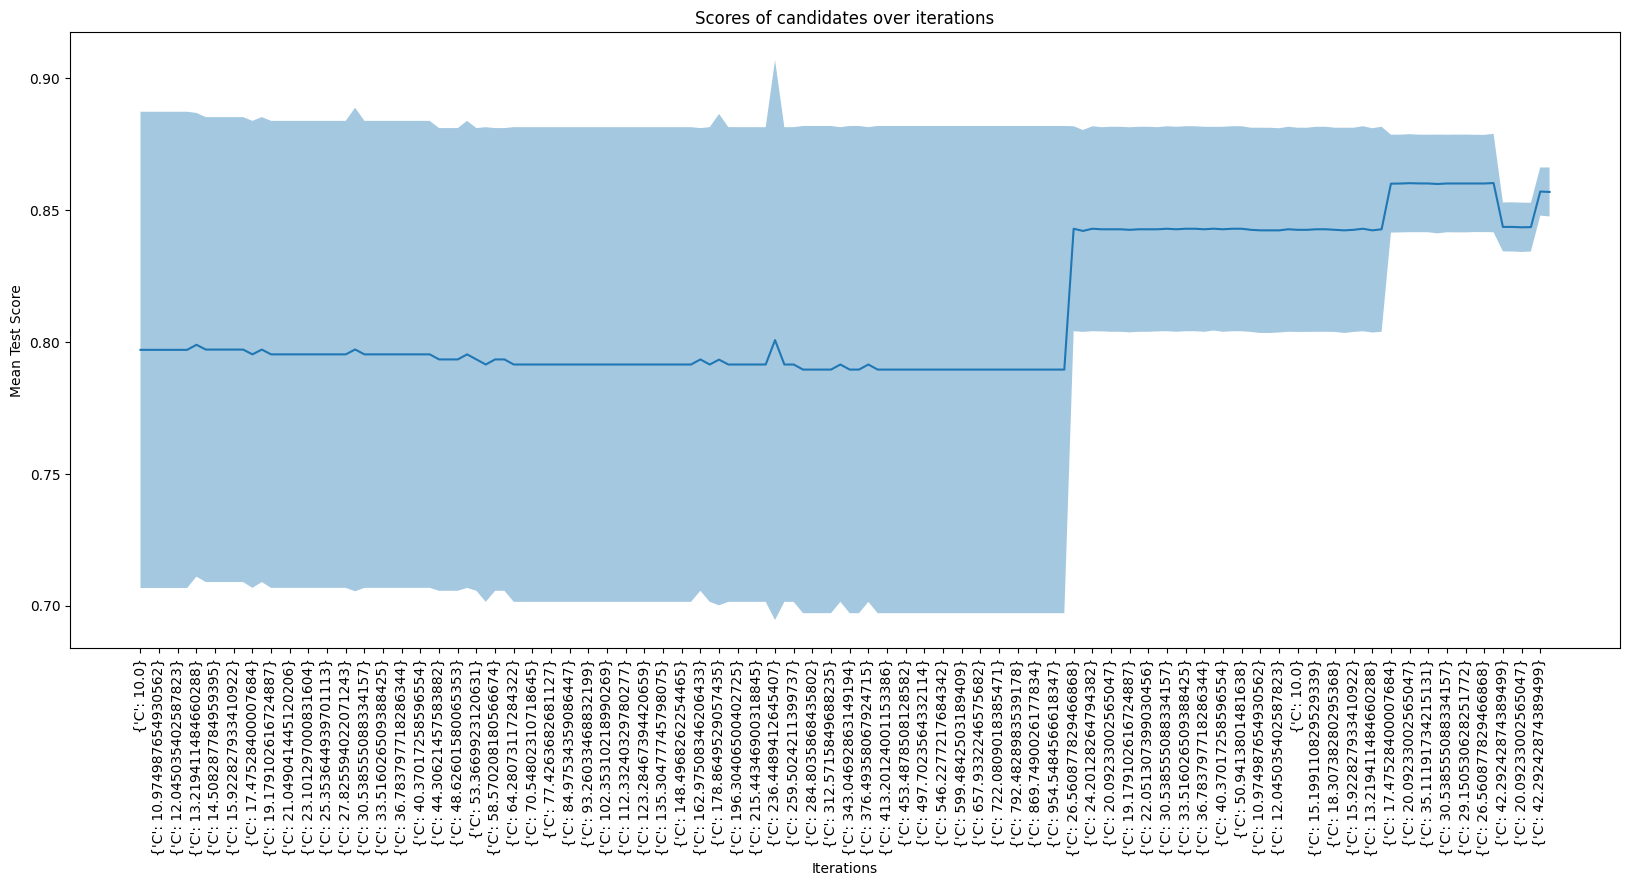

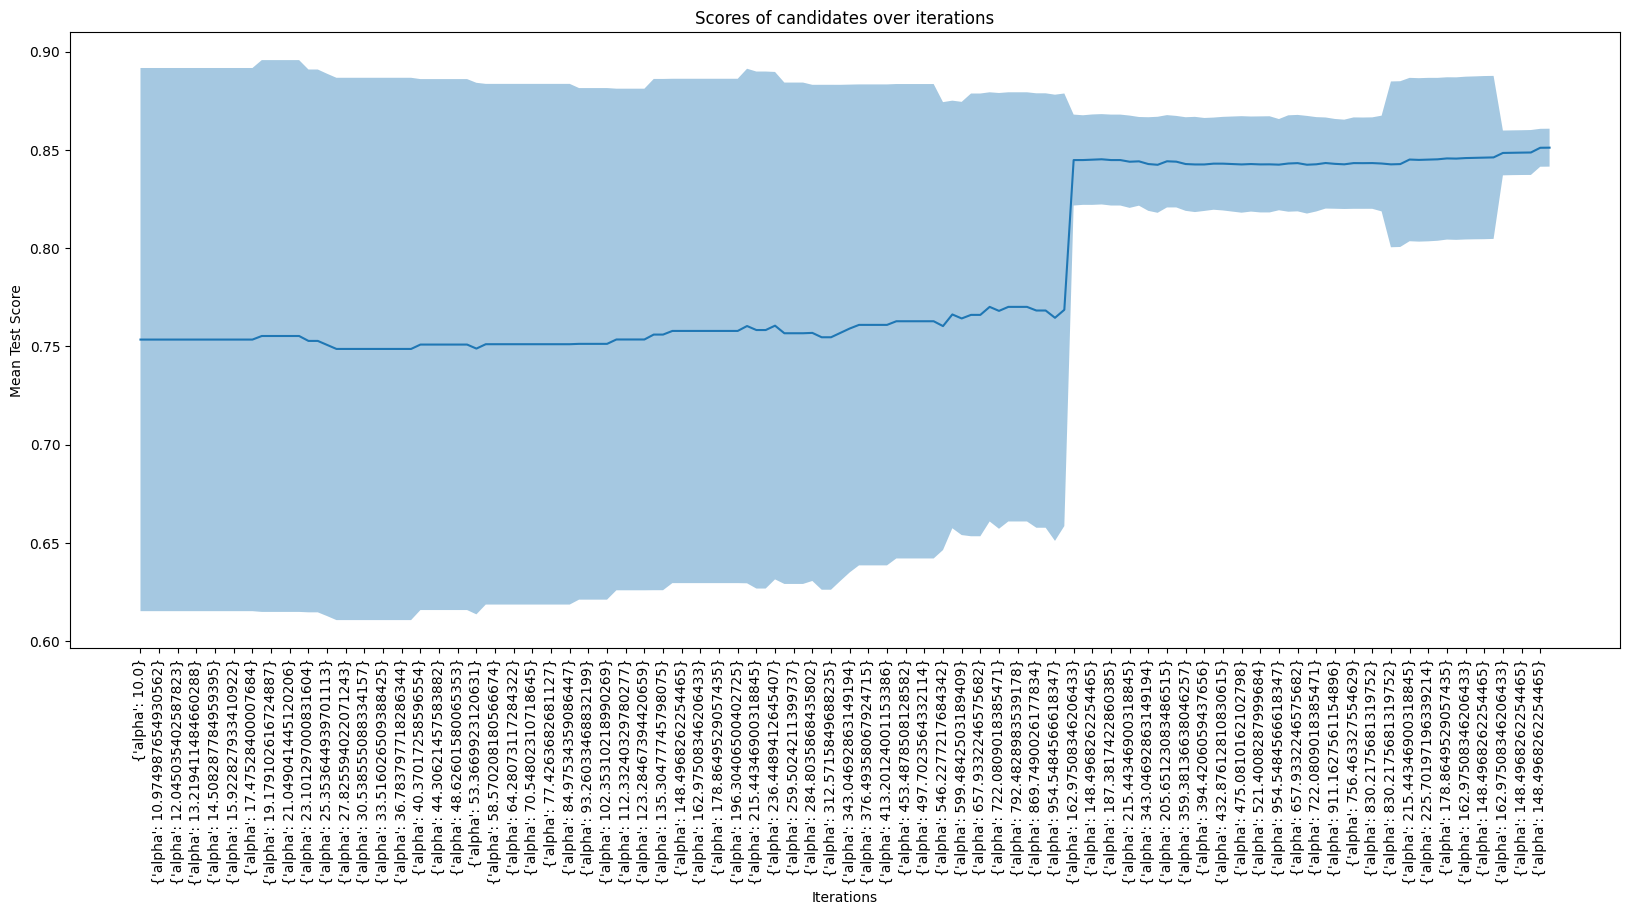

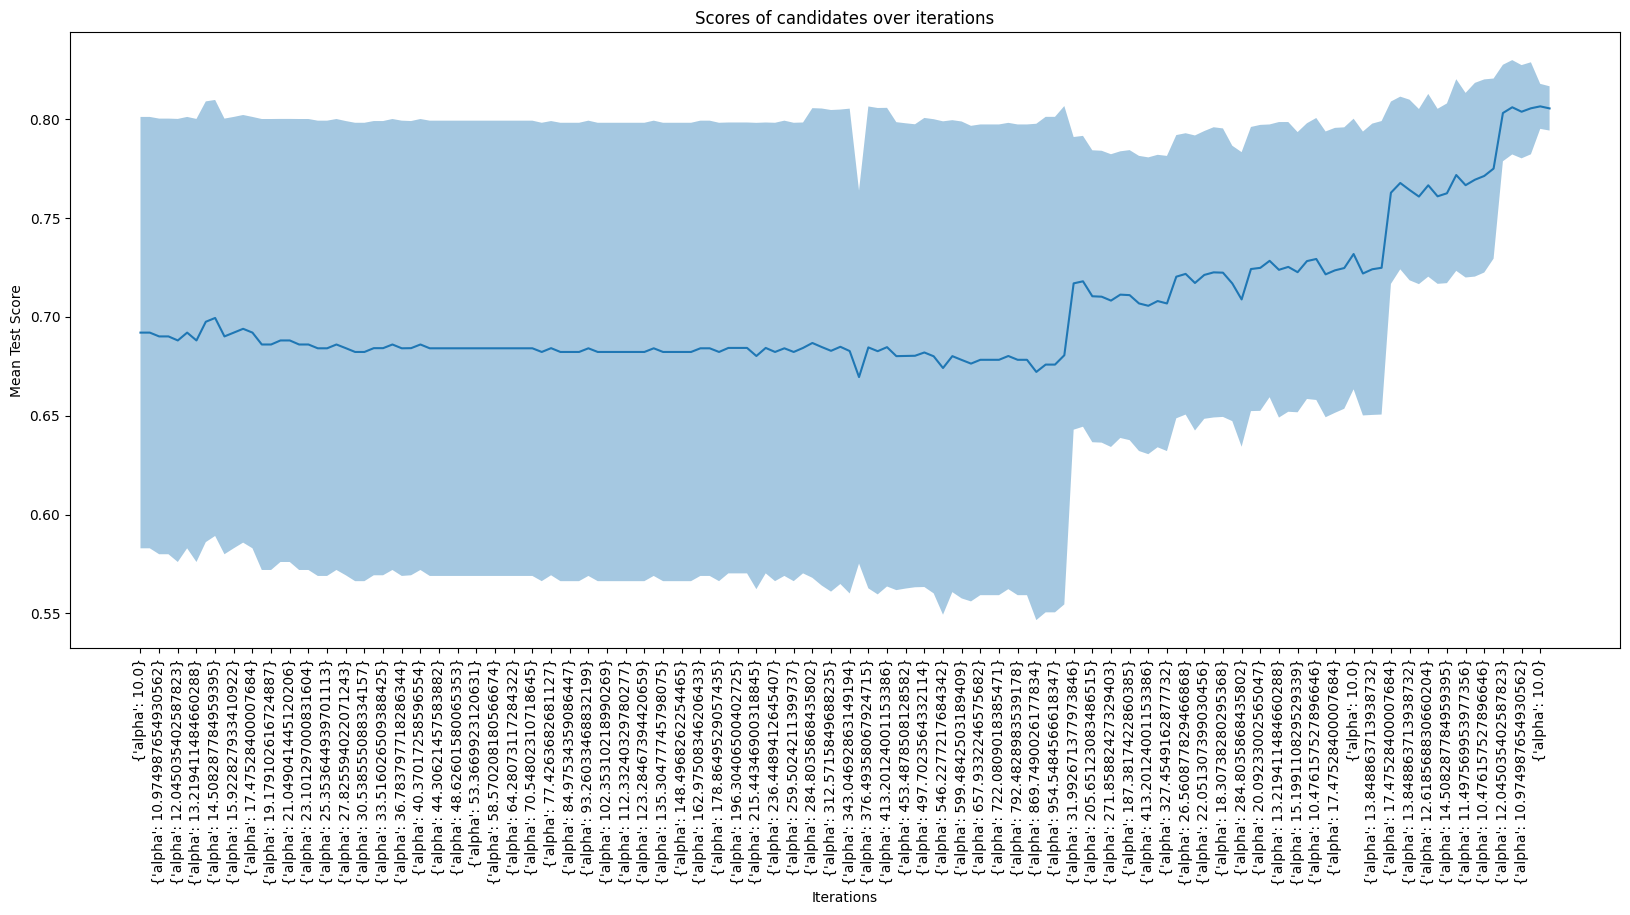

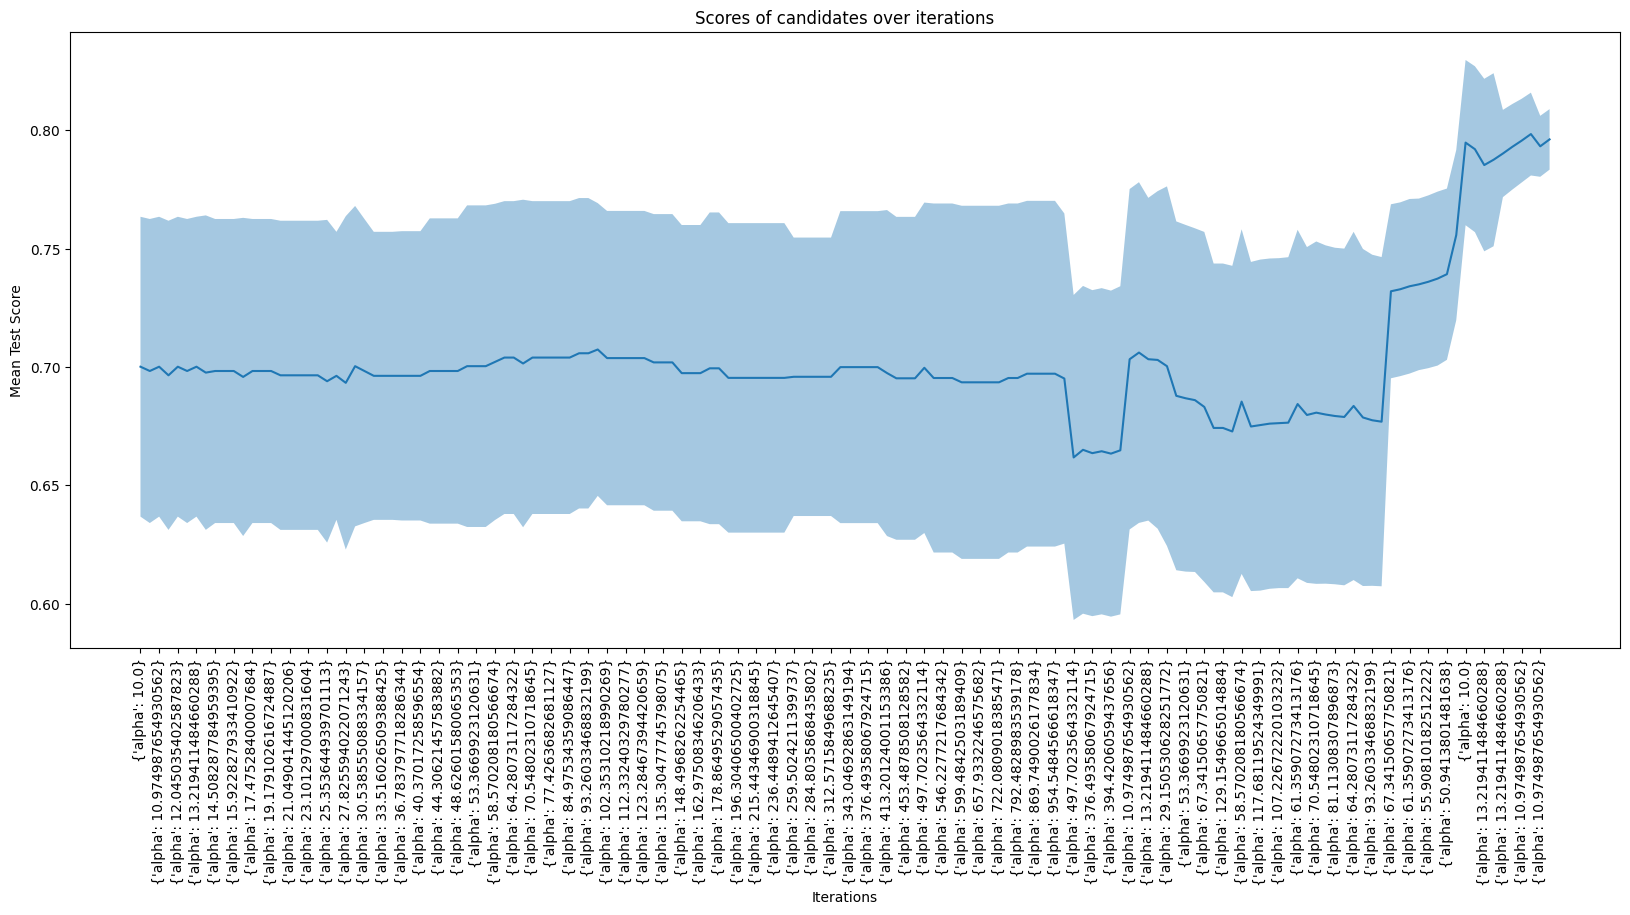

In [ ]:
a = (HalvingGridSearchCV(sklearn.linear_model.LogisticRegression(random_state = 42, max_iter=5000), c_param_grid, cv=cv, scoring='roc_auc').fit(X_train.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test).astype(int), y_test))
plot_scores(a)
a = (HalvingGridSearchCV(sklearn.linear_model.RidgeClassifier(random_state = 42, max_iter=5000), a_param_grid, cv=cv, scoring='roc_auc').fit(X_train.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test).astype(int), y_test))
plot_scores(a)
a = (HalvingGridSearchCV(sklearn.linear_model.SGDClassifier(random_state = 42, max_iter=5000), a_param_grid, cv=cv, scoring='roc_auc').fit(X_train.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test).astype(int), y_test))
plot_scores(a)
a =(HalvingGridSearchCV(sklearn.linear_model.SGDClassifier(random_state = 42, max_iter=5000, loss='log_loss'), a_param_grid, cv=cv, scoring='roc_auc').fit(X_train.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test).astype(int), y_test))
plot_scores(a)


#### Масштабирование

Посмотрим, можно ли улучшить качество классификации?

Посмотрим еще раз на данные.

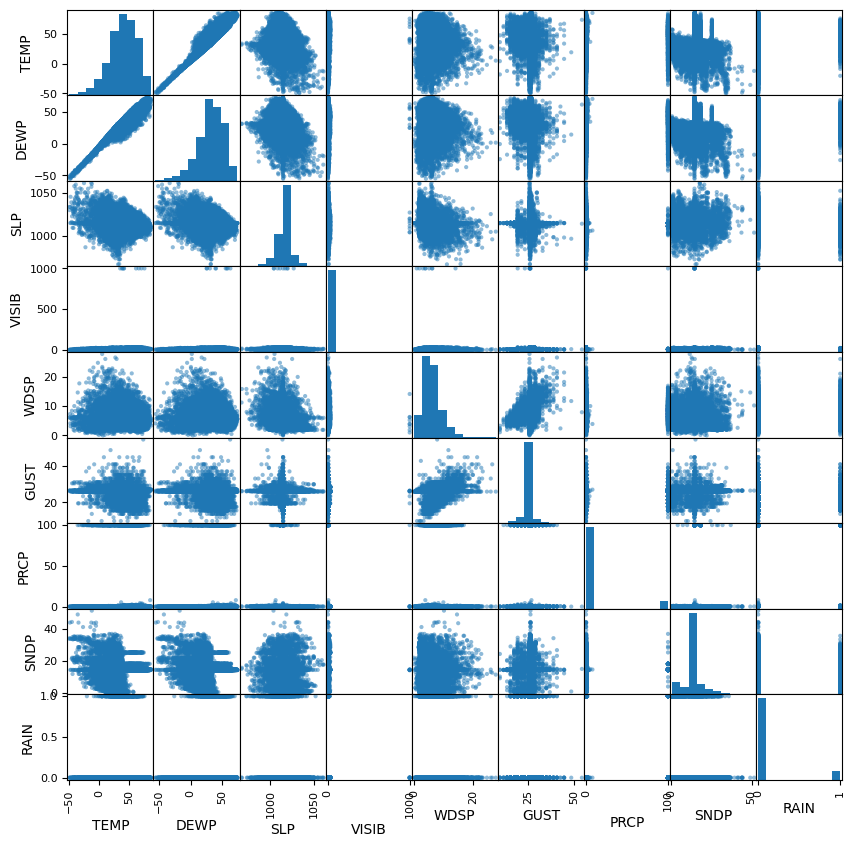

In [ ]:
scatter_matrix(pd.DataFrame(X), alpha=0.5, figsize=(10, 10));

Глядя на график выше, вы можете обратить внимание на отличия в диапазонах значений признаков, и вспомнить, как это влияет на обучение при использовании регуляризации.

Итак, требуется масштабировать признаки. Для этого используйте класс `StandardScaler` и его метод `fit_transform`.

In [ ]:
encoder = StandardScaler()
X = encoder.fit_transform(X)

Постройте `scatter_matrix` масштабированных признаков, чтобы убедиться в корректности работы метода.

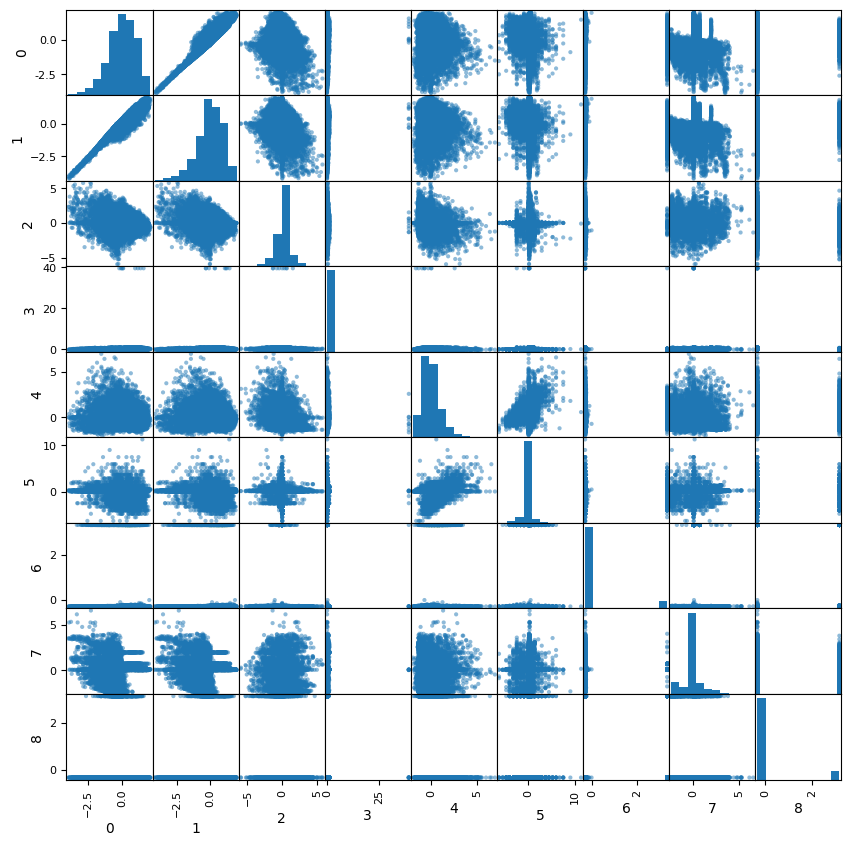

In [ ]:
scatter_matrix(pd.DataFrame(X), alpha=0.5, figsize=(10, 10));

Из графиков видно, что гистограммы распределений признаков не поменялись, а значит и свойства признакового пространства остались теми же, что были до масштабирования.

Повторите процесс обучения и подбора гиперпараметров для двух моделей, выбранных на предыдущем шаге.

Улучшится ли их результат?

0.8411688979231944
0.9735129207430033


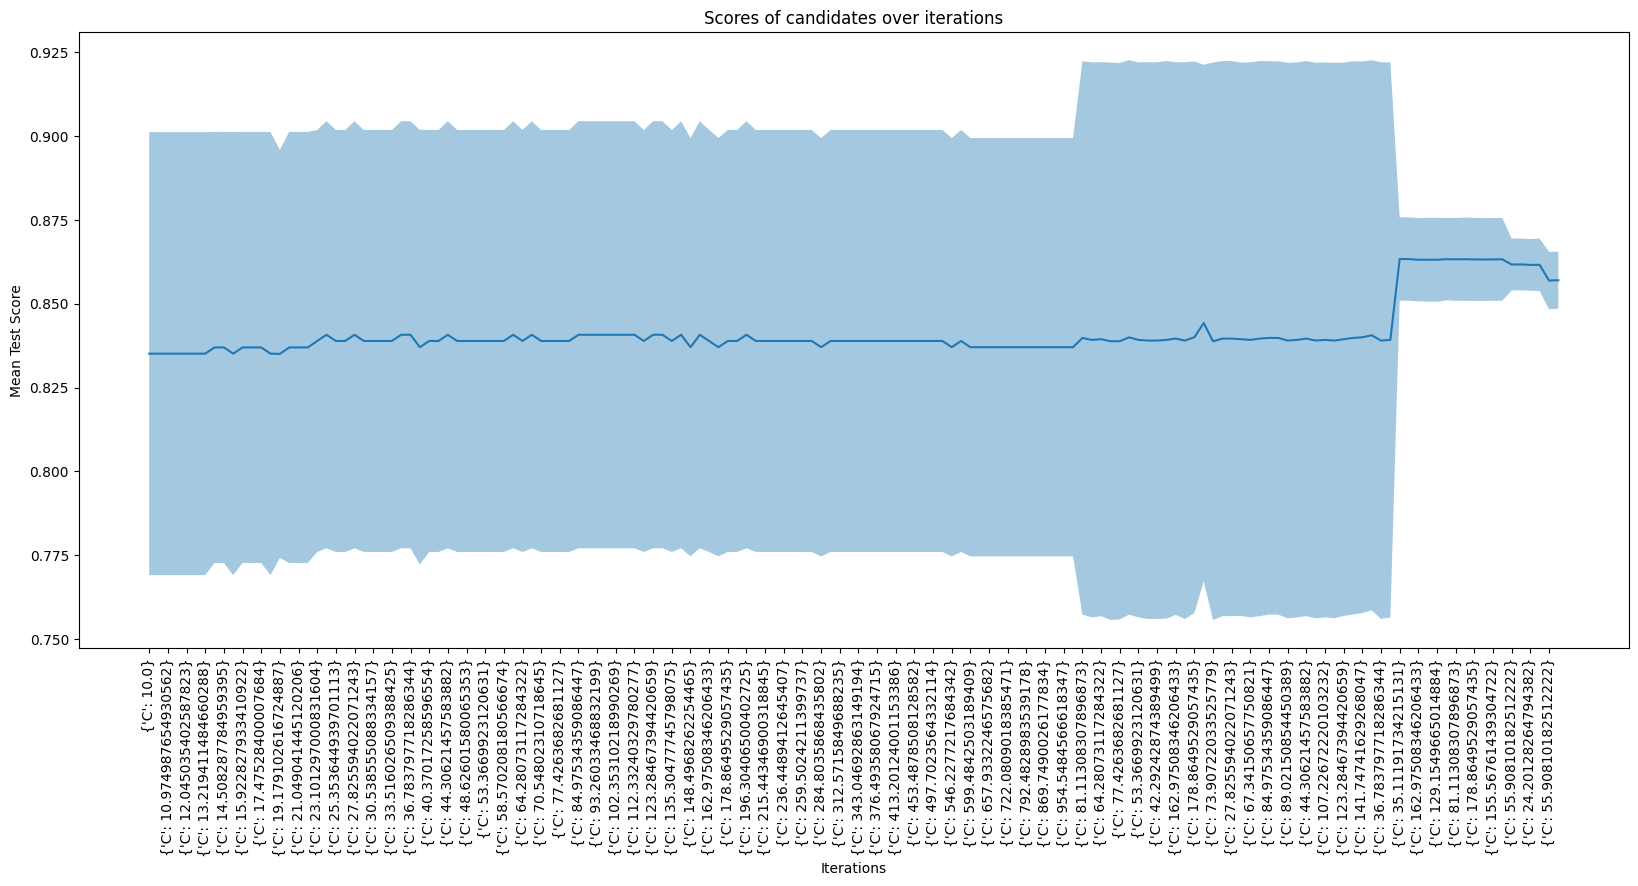

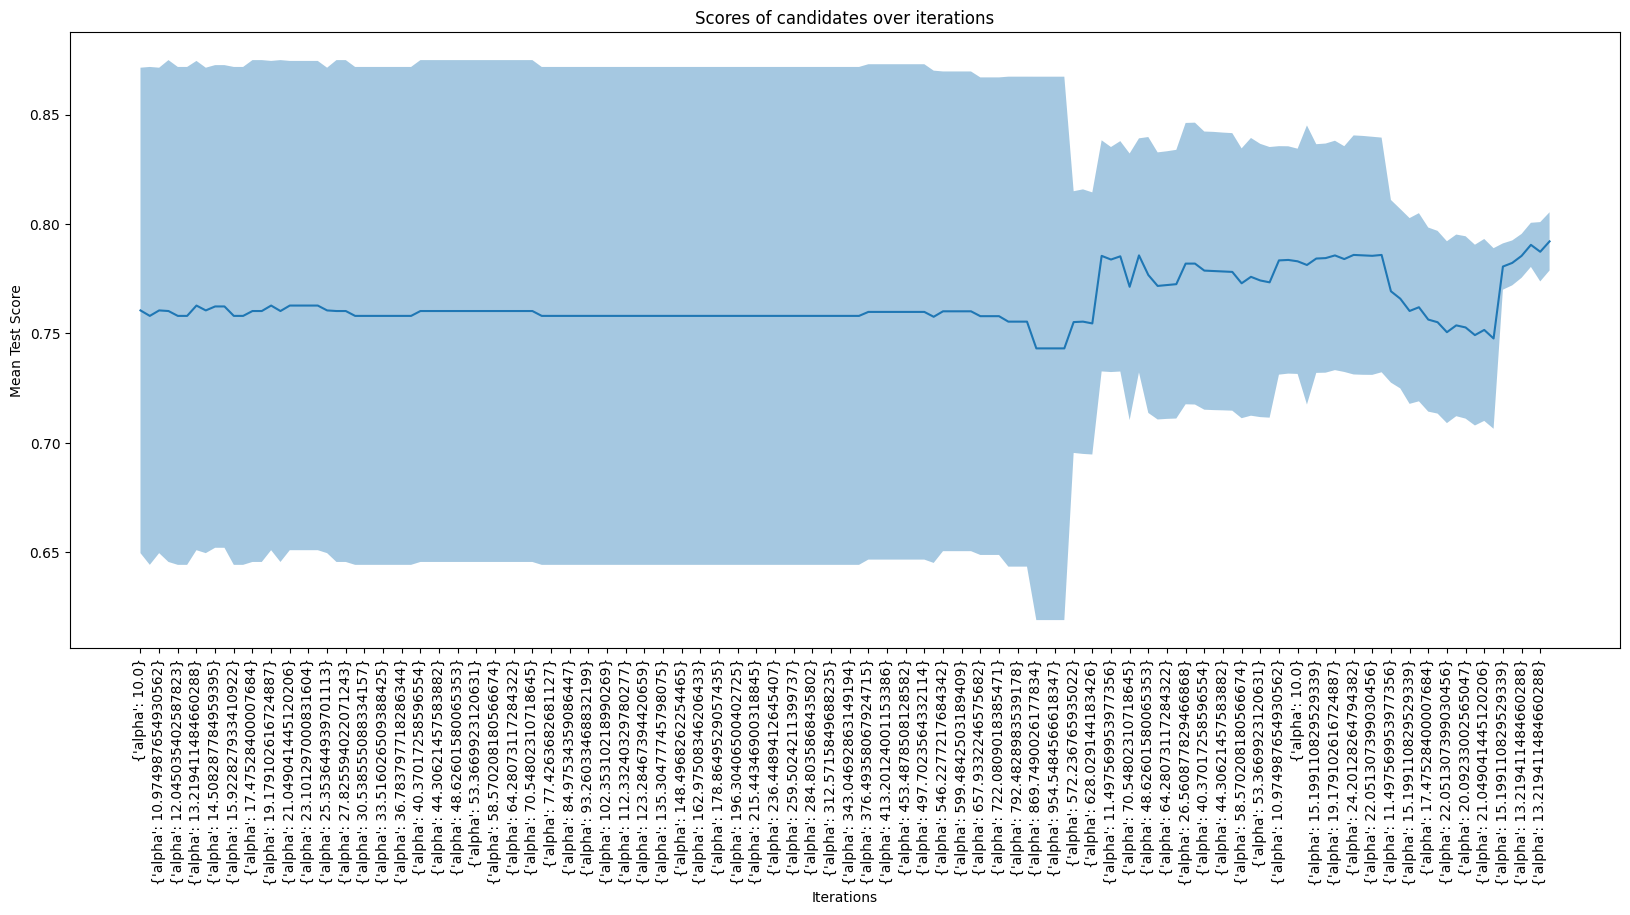

In [ ]:
a = (HalvingGridSearchCV(sklearn.linear_model.LogisticRegression(random_state = 42, max_iter=5000), c_param_grid, cv=cv, scoring='roc_auc').fit(X_train.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test).astype(int), y_test))
plot_scores(a)
a =(HalvingGridSearchCV(sklearn.linear_model.SGDClassifier(random_state = 42, max_iter=5000, loss='log_loss'), a_param_grid, cv=cv, scoring='roc_auc').fit(X_train.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test).astype(int), y_test))
plot_scores(a)

#### Полиномиальное преобразование признаков

Часто признаки взаимодействуют неожиданным и часто нелинейным образом. Эти взаимодействия могут быть идентифицированы и смоделированы алгоритмом обучения. Другой подход заключается в создании новых признаков, раскрывающих эти взаимодействия, и проверке того, улучшат ли они производительность модели. Кроме того, такие преобразования, как возведение входных переменных в степень, могут помочь лучше выявить важные взаимосвязи между входными переменными и целевой.

Эти признаки называются взаимодействующими (Feature Interaction) и полиномиальными (Polynomial Features) и позволяют использовать более простые алгоритмы моделирования, поскольку часть сложности интерпретации входных переменных и их взаимосвязей переносится на этап подготовки данных. Эти новые признаки могут привести к повышению производительности моделирования (а могут и не привести).

Таким образом, может быть полезно усложнить модель, учитывая нелинейные характеристики входных данных. Библиотека `sklearn` предоставляет две возможности, основанные на полиномах: первая использует полиномы (`PolynomialFeatures`), вторая использует сплайны (то есть кусочные полиномы - `SplineTransformer`).

Мы рассмотрим `PolynomialFeatures`, чтобы получить взаимодействующие признаки, а также признаки высокого порядка.<br>
Желающим ознакомиться с `SplineTransformer` - [сюда](https://scikit-learn.org/stable/modules/preprocessing.html#spline-transformer).

Пожалуй, стоит пояснить, что такое "взаимодействующие признаки". Когда признаки взаимодействуют друг с другом, результат не может быть выражен как сумма их эффектов, поскольку эффект одного зависит от значения другого. Если модель делает прогноз на основе двух признаков, то можно разложить прогноз на четыре слагаемых: постоянный член, слагаемое для первого признака, для второго признака и слагаемое для взаимодействия между двумя признаками. То есть взаимодействие между двумя признаками — это изменение прогноза, которое происходит за счет изменения признаков при учете их отдельных эффектов.

`PolynomialFeatures` генерирует полиномиальные и взаимодействующие признаки. Создает новую матрицу признаков, состоящую из всех полиномиальных комбинаций признаков со степенью, меньшей или равной указанной. Например, если входная выборка является двумерной: $[a, b]$, полиномиальные признаки степени 2 будут $[1, a, b, a^2, ab, b^2]$.

Вы могли обратить внимание, что в полученных полиномиальных признаках есть степень нуля (после из единиц). Тогда, чтобы не возникало линейной зависимости, нужно при инициализации модели использовать параметр `fit_intercept`.

Итак, от вас требуется:

* воспользоваться `PolynomialFeatures`, чтобы увеличить число признаков для обучения модели
* обучить и подобрать гиперпараметры для все тех же двух выбранных ранее моделей
* отобразить результат, чтобы понять, улучшилась ли классификация?

Следует также отметить, что преобразованные признаки следовало бы заново масштабировать, но так как преобразование вы будете применять к уже масшитабированным признакам, сейчас этот шаг опустим.

0.8874953166090951
0.7587252916946345


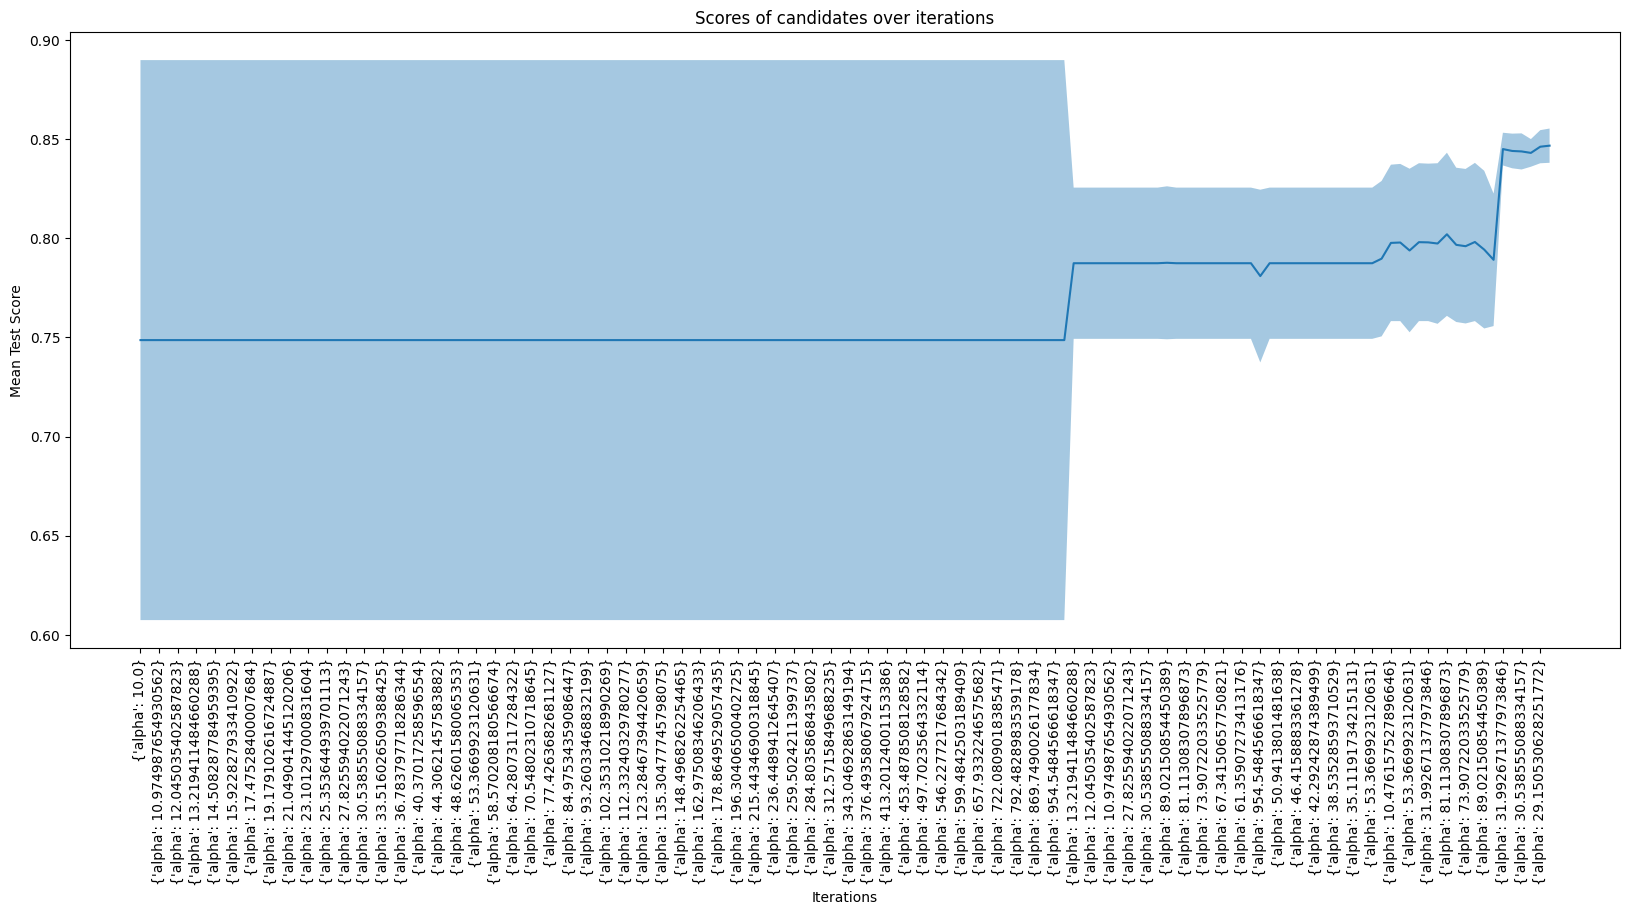

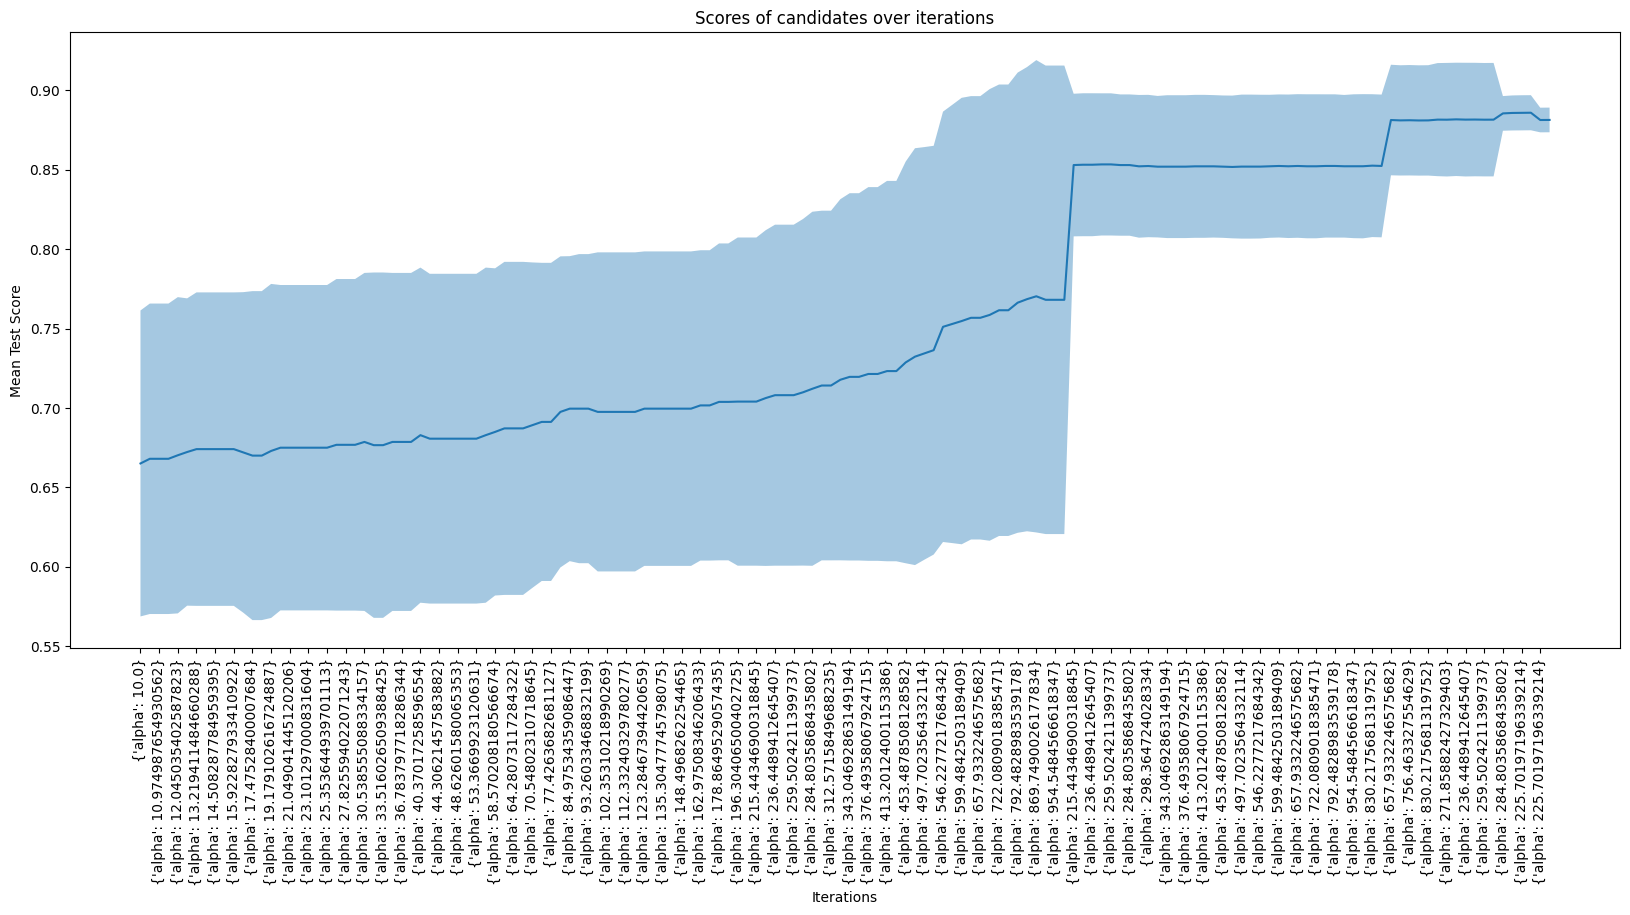

In [ ]:
transform = PolynomialFeatures()
X_train_poly = transform.fit_transform(X_train)
X_test_poly = transform.transform(X_test)
a =(HalvingGridSearchCV(sklearn.linear_model.SGDClassifier(random_state = 42, max_iter=10000, loss='log_loss'), a_param_grid, cv=cv, scoring='roc_auc').fit(X_train_poly.astype(int), y_train.astype(int)))
roc = a.predict(X_test_poly).astype(int)
print(sklearn.metrics.average_precision_score(roc, y_test))
plot_scores(a)
a = (HalvingGridSearchCV(sklearn.linear_model.RidgeClassifier(random_state = 42, max_iter=5000), a_param_grid, cv=cv, scoring='roc_auc').fit(X_train_poly.astype(int), y_train.astype(int)))
print(sklearn.metrics.average_precision_score(a.predict(X_test_poly).astype(int), y_test))
plot_scores(a)


#### Отбор признаков

Опциональный параметр `penalty` логистической регрессии позволяет применить L1-регуляризацию.

Обучите логистическую регрессию с использованием Lasso-регуляризации, используя отмасштабированные признаки.<br>
Можно попробовать применить метод и к полиномиальным признакам, однако, их значение зачастую сложно или невозможно интерпретировать.<br>
Обратите внимание, что алгоритм, используемый по умолчанию (`lbfgs`), не поддерживает L1-регуляризацию, поэтому также требуется использовать параметр `solver`, чтобы указать алгоритм `liblinear`.

Выведите названия признаков, чей модуль веса не превышает 0.5.

In [ ]:
sklearn.linear_model.LogisticRegression(random_state = 42, max_iter=10000, penalty='l1', solver='liblinear').fit(X_train.astype(int), y_train.astype(int)).best_estimator_.named_steps.model.coef_


"""
Для решения вам может быть полезен атрибут grid_search.best_estimator_.coef_
""".best_estimator_.named_steps.model.coef_

TypeError: ignored

### Оценка производительности

Постройте ROC-кривую для лучшей модели, полученной при обучении на полиномиальных признаках.

In [ ]:
transform = PolynomialFeatures()
X_train_poly = transform.fit_transform(X_train)
X_test_poly = transform.transform(X_test)
a =sklearn.linear_model.SGDClassifier(random_state = 42, max_iter=10000, loss='log_loss').fit(X_train_poly.astype(int), y_train.astype(int))


#define metrics
y_pred_proba = a.predict_proba(X_test)[::,1]
fpr, tpr, _ = sklearn.metrics.roc_curve (y_test, y_pred_proba)

#create ROC curve
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


ValueError: ignored

## Ансамбли
На отнормированных данных построить ансамбль `Soft Voting` и `Hard Voting` (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) из моделей

`LogisticRegression`

`SGDClassifier` (loss='log_loss')

`KNeighborsClassifier`

`XGBoost Classifier`

`RandomForestClassifier`

# Напишите пару строчек о проделанной работе

я поняла, что надо было ходить на лабы, и то что при простом удалении не заполненых строк не хватило бы для машинного обучения